In [70]:
import torch
import pyro
import pyro.optim
import pyro.infer
import pyro.distributions as dist
import pyro.contrib.autoguide as autoguide
import numpy as np
import time as tm
import pandas as pd

pyro.set_rng_seed(42)

N = 2500
P = 8
LEARNING_RATE = 1e-2
NUM_STEPS = 30000

alpha_true = dist.Normal(42.0, 10.0).sample()
beta_true = dist.Normal(torch.zeros(P), 10.0).sample()
sigma_true = dist.Exponential(1.0).sample()

eps = dist.Normal(0.0, sigma_true).sample([N])
x = torch.randn(N, P)
y = alpha_true + x @ beta_true + eps


def model(x, y):
    alpha = pyro.sample("alpha", dist.Normal(0.0, 100.0))
    with pyro.plate("P", P):
        beta = pyro.sample("beta", dist.Normal(0, 10.0))
    mu = alpha + x @ beta
    with pyro.plate("obs", N):
        sigma = pyro.sample("sigma", dist.HalfNormal(10.0))
        return pyro.sample("y", dist.Normal(mu, sigma), obs=y)


guide = autoguide.AutoDiagonalNormal(model)
optimiser = pyro.optim.Adam({"lr": LEARNING_RATE})
loss = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, guide, optimiser, loss)

losses = np.empty(NUM_STEPS)

pyro.clear_param_store()

start = tm.time()

for step in range(NUM_STEPS):
    losses[step] = svi.step(x, y)
    if step % 100.0 == 0:
        print(f"step: {step:>5}, ELBO loss: {losses[step]:.2f}", end = "\r")

print(f"\nfinished in {tm.time() - start:.2f} seconds")

step: 29900, ELBO loss: 5362.4413
finished in 154.78 seconds


Text(0, 0.5, 'ELBO loss')

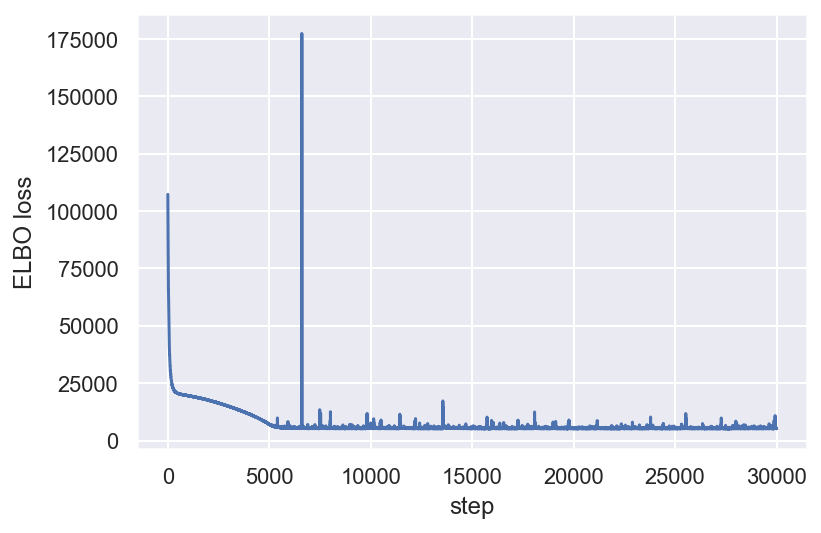

In [66]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel("step")
plt.ylabel("ELBO loss")

In [67]:
for key, value in pyro.get_param_store().items():    
    print(f"{key}:\n{value}\n")

AutoDiagonalNormal.loc:
Parameter containing:
tensor([45.3777,  1.2966,  2.3513,  ..., -0.4852,  0.5626,  0.7242],
       requires_grad=True)

AutoDiagonalNormal.scale:
tensor([0.0032, 0.0046, 0.0037,  ..., 1.1386, 1.0259, 1.1107],
       grad_fn=<AddBackward0>)



In [68]:
true_values = torch.cat([alpha_true.reshape(-1), beta_true, sigma_true.reshape(-1)])
true_names = ["alpha", *[f"beta[{i}]" for i in range(P)], "sigma"]

loc = pyro.get_param_store().get_param("AutoDiagonalNormal.loc").detach().numpy()[:P+2]
scale = pyro.get_param_store().get_param("AutoDiagonalNormal.scale").detach().numpy()[:P+2]

true_dict = {"names": true_names, "truth": true_values, "loc": loc, "scale": scale}
true_data = pd.DataFrame(true_dict).set_index("names")

true_data.round(4)

10 10 10


,truth,loc,scale
names,,,
alpha,45.366901,45.377701,0.0032
beta[0],1.288100,1.296600,0.0046
beta[1],2.344600,2.351300,0.0037
beta[2],2.303300,2.288800,0.0032
beta[3],-11.228600,-11.232700,0.0044
beta[4],-1.863300,-1.859500,0.0030
beta[5],22.082001,22.082100,0.0020
beta[6],-6.380000,-6.380600,0.0034
beta[7],4.616600,4.613900,0.0028
